
🧠 OpenAI responde:

El dataset presenta 5000 registros y 13 columnas, lo que indica un tamaño adecuado para análisis. Sin embargo, se identifican 888 valores nulos, lo que representa aproximadamente el 17.76% del total de datos. Esto podría impactar negativamente en los resultados de cualquier análisis estadístico, ya que hay una cantidad significativa de datos faltantes que podrían ser cruciales para la interpretación.

Además, no se encuentran duplicados, lo que es positivo. No obstante, los outliers en campos como 'Rank', '$Worldwide', '$Domestic', '$Foreign', y 'Vote_Count' requieren atención, especialmente los outliers en '$Worldwide' y 'Vote_Count', que podrían influir desproporcionadamente en las estadísticas generales del dataset.

Se aconseja realizar una imputación de datos para manejar los valores nulos, considerando técnicas como la imputación por medias, medianas o utilizando modelos predictivos. Adicionalmente, se debe investigar más a fondo los outliers para determinar 

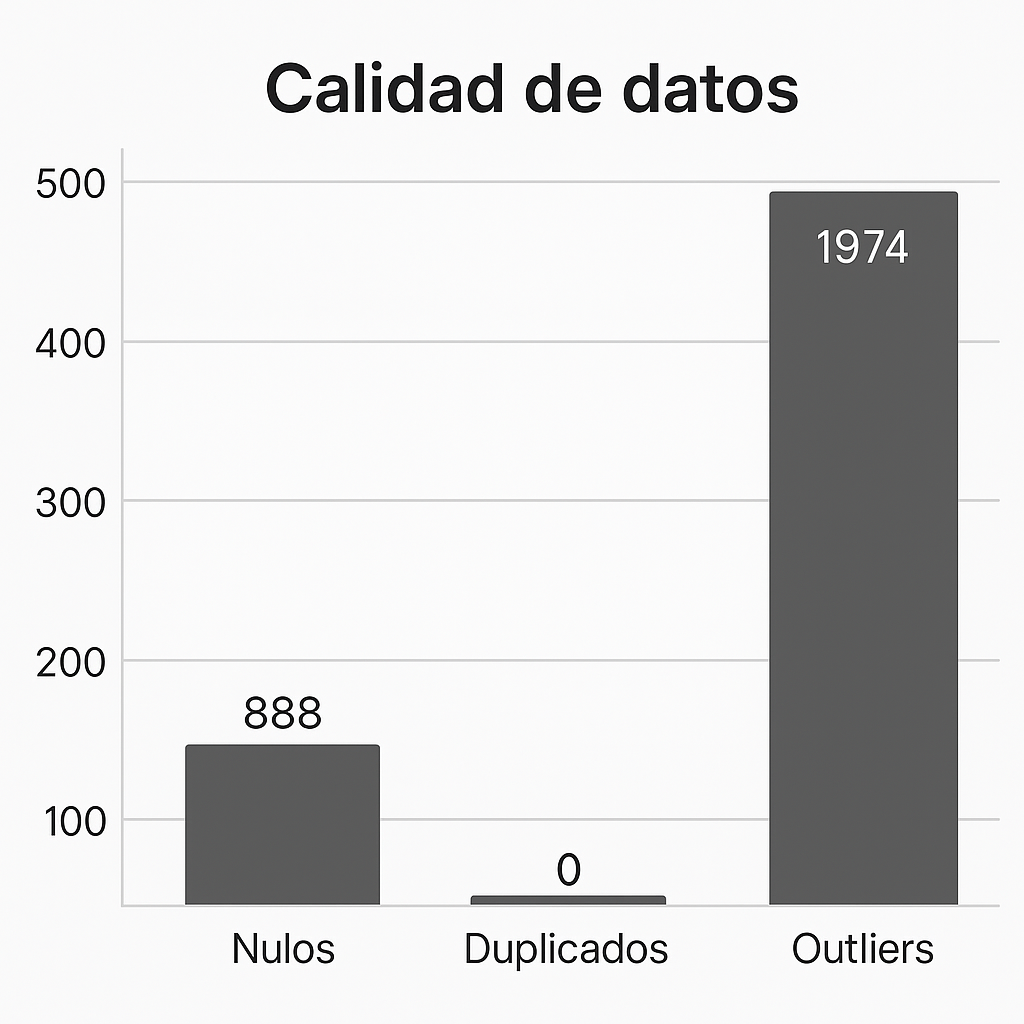

In [4]:
import pandas as pd
import os
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import display
import base64
from PIL import Image
import io


load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_KEY:
    print("⚠️ Falta la clave de OpenAI en el archivo .env")


client = OpenAI(api_key=OPENAI_KEY)

csv_path = "dataset.csv"   
df = pd.read_csv(csv_path)



nulos = df.isnull().sum().sum()
duplicados = df.duplicated().sum()


outliers = {}
for col in df.select_dtypes(include=["int64", "float64"]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers[col] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()


prompt_texto = f"""
Analiza este dataset y detecta problemas de calidad:
- Tamaño: {df.shape}
- Nulos: {nulos}
- Duplicados: {duplicados}
- Outliers: {outliers}


Responde de forma breve y clara, en varios renglones.
Por ultimo da un breve consejo de que hacer segun como esten esos datos.
"""

if OPENAI_KEY:
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Eres un experto en análisis de datos."},
                {"role": "user", "content": prompt_texto}
            ],
            max_tokens=300
        )
        print("\n🧠 OpenAI responde:\n")
        print(response.choices[0].message.content)
    except Exception as e:
        print("❌ Error con OpenAI:", e)



prompt_visual = (
    f"Genera un gráfico de barras que muestre tres problemas de calidad de datos. "
    f"Categorías: 'Nulos' ({nulos}), 'Duplicados' ({duplicados}), 'Outliers' ({sum(outliers.values())}). "
    "Cada barra debe incluir el número exacto encima o dentro de la barra. "
    "El diseño debe ser simple, con etiquetas claras en español, fondo blanco, colores sobrios, "
    "y título 'Calidad de datos'."
)

try:
    result = client.images.generate(
        model="gpt-image-1",
        prompt=prompt_visual,
        size="auto"
    )

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)

    img = Image.open(io.BytesIO(image_bytes))
    display(img)
    img.save("infografia_calidad.png")
except Exception as e:
    print("❌ Error al generar imagen con OpenAI:", e)



